In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torch import optim

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time, os

%matplotlib inline

In [2]:
args = {
    'epoch_num': 100,
    'lr': 1e-3,
    'weight_decay': 1e-3,
    'batch_size': 50,
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


---

In [3]:
net = nn.Sequential(
    # entrada (b, 3, 32, 32) saida (b, 6, 28, 28)
    nn.Conv2d(3, 6, kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Tanh(),
    # entrada (b, 3, 28, 28) saida (b, 6, 14, 14)
    nn.AvgPool2d(kernel_size=2),

    # entrada (b, 6, 14, 14) saida (b, 16, 10, 10)
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Tanh(),
    # entrada (b, 16, 10, 10) saida (b, 16, 5, 5)
    nn.AvgPool2d(kernel_size=2),

    # entrada (b, 16, 5, 5) saida (b, 120, 1, 1)
    nn.Conv2d(16, 120, kernel_size=5),
    nn.BatchNorm2d(120),
    nn.Tanh(),
    nn.Flatten(),

    # entrada (b, 16, 5, 5) saida (b, 84)
    nn.Linear(120, 84),
    nn.Tanh(),
    # entrada (b, 84) saida (b, 10)
    nn.Linear(84, 10)
).to(args['device'])

print(net)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Tanh()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Tanh()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): Tanh()
  (14): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
data_transform = transforms.Compose([
                                     transforms.Resize(32),
                                     transforms.ToTensor(),])

train_set = datasets.CIFAR10('.',
                      train=True,
                      transform=data_transform,
                      download=True)

test_set = datasets.CIFAR10('.',
                      train=False,
                      transform=data_transform,
                      download=False)

Files already downloaded and verified


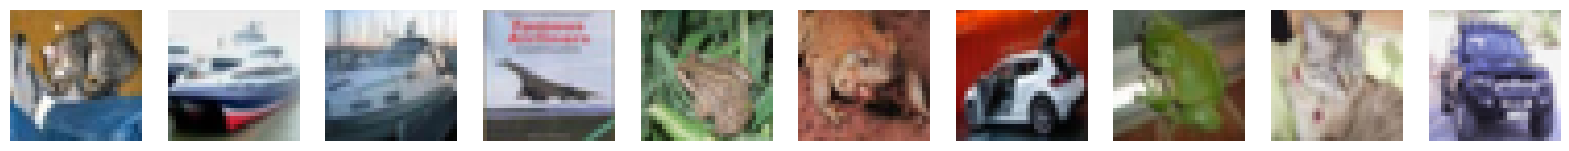

In [5]:
fig, axs = plt.subplots(1,10, figsize=(20, 2))
for i in range(10):
  data, label = test_set[i]
  axs[i].imshow(data.permute((1,2,0)))
  axs[i].axis('off')

In [6]:
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True)

test_loader = DataLoader(test_set,
                         batch_size=args['batch_size'],
                         shuffle=True)

In [7]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
for epoch in range(args['epoch_num']):
    epoch_loss = []
    for batch in train_loader:
        dado, rotulo = batch
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])

        y_pred = net(dado)
        loss = criterion(y_pred, rotulo)
        epoch_loss.append(loss.detach().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.array(epoch_loss)
    print(epoch_loss.mean())

In [13]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()

  start = time.time()

  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:

    dado, rotulo = batch

    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))

  return epoch_loss.mean()

In [14]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()

  start = time.time()

  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad():
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)

  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))

  return epoch_loss.mean()

In [ ]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):

  # Train
  train_losses.append(train(train_loader, net, epoch))

  # Validate
  test_losses.append(validate(test_loader, net, epoch))

Text(0.5, 0, 'Epochs')

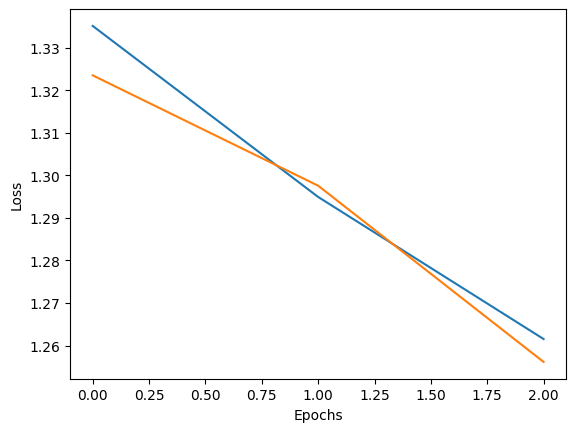

In [16]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')